# The `shrinkage` library: user's guide

First, import `numpy` and `matplotlib.pyplot` as general tools used throughout this user guide:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Make sure you can import from the `shrinkage` library:

In [2]:
from shrinkage import __version__

__version__

'1.0.0'

For theoretical background of _shrinkage estimators_ in large-dimensional statistics, see articles in the directory `papers`.

# 1. Multivariate simulation (`SampleEigenvalues` class)

In this section, we will discuss the `shrinkage.simulation` module, in particular the `SampleEigenvalues` class, and its functionalities related to simulating a data matrix $\mathbf{Y}$. We will also mention the `PopulationCovariance` and `AutoCovariance` classes, which encapsulate the parameter matrices $\mathbf{C}$ and $\mathbf{A}$, respectively, of the "sandwich" model.

In [3]:
from shrinkage.simulation import SampleEigenvalues, PopulationCovariance, AutoCovariance

## 1.1. Introduction

In _large-dimensional statistics_, one considers some $N$ entities of interest, and observes them over the course of $T_{\textrm{total}}$ samples. The name of the regime - otherwise known as a _big data regime_ or _Kolmogorov regime_ - signifies that both $N$ and $T_{\textrm{total}}$ are large and of comparable size. This is in contradistinction to standard multivariate statistics, in which $N$ is small compared to $T_{\textrm{total}}$, i.e. we have many more samples than the entities to estimate. For this reason, usual statistical methods fail in the big data regime; for instance, well-known sample estimators are no longer optimal. One has to make use of a totally different toolbox, in particular methods of so-called _random matrix theory_.

But before we go into these more advanced topics, we need to have some ("big") data to work with. In other words, we need to have a data matrix $\mathbf{Y}$, of shape $N \times T_{\textrm{total}}$, representing the collected samples of our observed entities. This matrix may come from some experimental data source. You may think of $N \sim$ a few hundred stocks of the S&P500 index, for which we collect daily returns over the couse of a few years, $T_{\textrm{total}} \sim$ hundreds to thousands. You may think of $N \sim$ a few dozen differentially expressed genes, obsrved in $T_{\textrm{total}} \sim$ a few snapshots of a microarray experiment (here $\mathbf{Y}$ is called a "gene expression matrix"). This is a very generic situation in many areas of science.

Still before we investigate any real-world example, we may alternatively _simulate_ the matrix $\mathbf{Y}$. This will let us both verify theoretical ideas encapsulated in this library, as well as learn its syntax in a controlled environment.

## 1.2. The "sandwich" model

The simulation models supported so far will all have the same "sandwich" form:

- first, generate IID random numbers from either the standard normal or standard Student-t distribution, collected in a random matrix $\mathbf{X}$, of the shape as above;

- then "sandwich" it with square roots of a _population matrix_ $\mathbf{C}$, and an _auto-correlation matrix_ $\mathbf{A}$, like so, $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X} \sqrt{\mathbf{A}}$; these two matrices of model parameters are positive semi-definite real symmetric, of shapes $N \times N$ and $T_{\textrm{total}} \times T_{\textrm{total}}$, respectively.

This prescription makes sure that the two-point average, $\langle Y_{i t} Y_{j s} \rangle = C_{i j} A_{t s}$; in other words, we have some specified cross-correlations $C_{i j}$ between the entities, and - completely decoupled from them - correlations between the samples themselves, $A_{t s}$.

### 1.2.1. Models of the population correlation matrix (`PopulationCovariance` class)

To simulate such a "sandwich" model, we need to specify the population correlation matrix $\mathbf{C}$, and the auto-correlation matrix $\mathbf{A}$. The former can be generated via an instance of the `PopulationCovariance` class. We need to specify its size `N`, and crucially, a model (`C_model`) from which to build the matrix; supported models include:

- the default is `C_model='unit'`: $\mathbf{C}$ is the unit matrix.

- `C_model='clusters'`: $\mathbf{C}$ is diagonal, with eigenvalues defined in a list `e_list`, each eigenvalue appearing a given fraction of times of $N$, the fractions collected in a list `f_list`; this has length one less than `e_list`, as the fractions need to sum up to one, so the last one need not be stated.

- `C_model='inverse-Wishart'`: $\mathbf{C}$ will have random eigenvalues from the _inverse Wishart_ distribution. We specify a parameter `kappa` ($\kappa$); calculate $q_{ \textrm{IW} } = 1 / (1 + 2 \kappa)$, then $T_{ \textrm{IW} } = N / q_{ \textrm{IW} }$ (integer part of it); generate a random matrix $\mathbf{R}$ of shape $N \times T_{ \textrm{IW} }$, and form from it a Wishart random matrix, $\mathbf{W} = \frac{1}{T_{ \textrm{IW} }} \mathbf{R} \mathbf{R}^{\top}$; finally, $\mathbf{C} = (1 - q_{ \textrm{IW} }) \mathbf{W}^{-1}$.

- `C_model='Kumaraswamy'`: $\mathbf{C}$ will have random eigenvalues from the _Kumaraswamy_ distribution. We specify parameters `a` ($a$), `b` ($b$), and `condition_number` ($c$); generate a random vector $\mathbf{r}$ of length $N$, and let $\mathbf{k} = (1 - (1 - \mathbf{r})^{1 / b})^{1 / a}$; finally, the eigenvalues of $\mathbf{C}$ are defined as $1 + (c - 1) \mathbf{k}$.

In some of these cases we generate only the eigenvalues of $\mathbf{C}$; such a diagonal matrix may then be optionally (`rotate_C=True`) rotated by a random (with the Haar measure) orthogonal matrix, $\mathbf{O} \mathbf{C} \mathbf{O}^{\top}$. Our formalism, however, is invariant w.r.t. to such similarity transformations, and so this step should have no effect on any result.

After instantiating the class with the above parameters, the resulting matrix $\mathbf{C}$ resides in the `C` attribute, while its square root $\sqrt{\mathbf{C}}$ in `sqrt_C`.

In all examples in this tutorial we will have:

In [4]:
N = 500

Let's look at some examples:

(1) clustered eigenvalues:

In [5]:
population_covariance_1 = PopulationCovariance(
    N=N,
    C_model='clusters',
    f_list=[0.5],
    e_list=[1., 3.],
    rotate_C=True
)

In [6]:
population_covariance_1.C.shape

(500, 500)

In [7]:
population_covariance_1.sqrt_C.shape

(500, 500)

(2) inverse-Wishart eigenvalues:

In [8]:
population_covariance_2 = PopulationCovariance(
    N=N,
    C_model='inverse-Wishart',
    kappa=2.,
    rotate_C=True
)

In [9]:
population_covariance_2.C.shape

(500, 500)

In [10]:
population_covariance_2.sqrt_C.shape

(500, 500)

(3) Kumaraswamy eigenvalues:

In [11]:
population_covariance_3 = PopulationCovariance(
    N=N,
    C_model='Kumaraswamy',
    a=0.3,
    b=0.7,
    condition_number=5.,
    rotate_C=True
)

In [12]:
population_covariance_3.C.shape

(500, 500)

In [13]:
population_covariance_3.sqrt_C.shape

(500, 500)

### 1.2.2. Models of the auto-correlation matrix (`AutoCovariance` class)

The auto-correlation matrix $\mathbf{A}$ is similarly defined as the attribute `A` of an instance of the `AutoCovariance` class. Analogously as above, we need to specify `T_total`, and crucially a model (`A_model`), out of:

- the default is `A_model='unit'`: $\mathbf{A}$ is the unit matrix.

- `A_model='VARMA'`: $\mathbf{A}$ comes from a broad family of VARMA processes. In particular, a $\textrm{VARMA}(r_{1}, r_{2})$ process is defined via the following recurrence relation:
  $$
  Y_{i, a} = \sum_{\beta = 1}^{r_{1}} b_{\beta} Y_{i, a - \beta} + \sum_{\alpha = 0}^{r_{2}} a_{\alpha} \epsilon_{i, a - \alpha}
  $$
  Here $\epsilon$ is a matrix of IID standard Gaussian or Student-t variables. Such a process has $(r_{2} + 1)$ "MA" parameters $a_{\alpha}$, and $r_{1}$ "AR" parameters $b_{\beta}$; we provide them via the attributes `a_list` and `b_list`. In this class, however, we are not performing any such simulation; rather, we make use of the fact that the matrix $\mathbf{A}$ is known for such a process, and we construct it explicitly. Note that internally, we instantiate here an object of the class `Varma` from the `varma` module; upon instantiation, the matrix $\mathbf{A}$ is calculated via the private method `_calculate_A`.

- `A_model='exp-decay'`: This is a simple sub-type of the VARMA case; indeed, a VAR(1) model with a particular set of parameters, $b_{1} = \textrm{e}^{-1 / \tau}$ and $a_{0} = \sqrt{1 - b_{1}^{2}}$, has a very simple auto-correlation matrix, a Toeplitz matrix $A_{t s} = a(|t - s|)$, with $a(t) = \textrm{e}^{-t / \tau}$; this thus models the simplest exponentially-decaying auto-correlations, with correlation time $\tau$ (`tau`).

- `A_model='EWMA'`: An exponentially-weighted moving average (EWMA) estimator can be modeled within the current framework with an auto-correlation matrix, $A_{t s} = T \frac{ 1 - \epsilon }{ 1 - \epsilon^{T} } \epsilon^{t - 1} \delta_{t s}$, for a constant $\epsilon$. In the context of large-dimensional statistics, and for the reason of computational tractability, one should consider the following limit, $\epsilon = 1 - \frac{ \delta }{ T }$, at large $T$, for some given $\delta$ (`delta`).

Again, we may optionally (`rotate_A=True`) perform a Haar-measure random orthogonal similarity transformation on such an $\mathbf{A}$.

Instantiation of the class readily calculates $\mathbf{A}$ (attribute `A`), as well as $\sqrt{\mathbf{A}}$ (attribute `sqrt_A`).

Some examples:

In [14]:
T_total = 1500

(1) VARMA:

In [15]:
auto_covariance_1 = AutoCovariance(
    T_total=T_total,
    A_model='VARMA',
    a_list=[0.8, 0.4],
    b_list=[0.3],
    rotate_A=False
)

In [16]:
auto_covariance_1.A.shape

(1500, 1500)

In [17]:
auto_covariance_1.sqrt_A.shape

(1500, 1500)

(2) exponential decay:

In [18]:
auto_covariance_2 = AutoCovariance(
    T_total=T_total,
    A_model='exp-decay',
    tau=2.5,
    rotate_A=False
)

In [19]:
auto_covariance_2.A.shape

(1500, 1500)

In [20]:
auto_covariance_2.sqrt_A.shape

(1500, 1500)

(3) exponentially-weighted moving average:

In [21]:
auto_covariance_3 = AutoCovariance(
    T_total=T_total,
    A_model='EWMA',
    delta=5.,
    rotate_A=False
)

In [22]:
auto_covariance_3.A.shape

(1500, 1500)

In [23]:
auto_covariance_3.sqrt_A.shape

(1500, 1500)

## 1.3. Simulating from the "sandwich" model

### 1.3.1. Simulation and eigenvalues (`SampleEigenvalues` class)

Having understood what the "sandwich" model is, and what kinds of $\mathbf{C}$ and $\mathbf{A}$ matrices are supported, we may finally simulate a data matrix $\mathbf{Y}$. We do so within the main class of the `shrinkage.simulation` module, `SampleEigenvalues`, which we instantiate with `method='sandwich'`. Other instantiation parameters are:

- `N`.

- `T`: This $T$ will be an "effective" number of samples, rather than $T_{ \textrm{total} }$; to be sure, we will always simulate $T_{ \textrm{total} }$ samples, but only $T$ of them will be used in most situations; the remaining ones are needed for one purpose only: a certain out-of-sample estimation procedure of the so-called oracle estimator.

- `T_total`: It is $2 T$ by default, and may well be left at this value. Once again, this means that we will simulate $2 T$ samples, out of which only $T$ will be used in all situations but one (the oracle estimator).

- `dist`: Defines a distribution of the random noise $\mathbf{X}$; `'Gaussian'` by default (then the entries of $\mathbf{X}$ are IID standard normal random variables), may also be `'Student-t'` (in which case set `df` = degrees of freedom; the entries are IID standard Student-t variables).

- `C_model` and `A_model`: As above; both `'unit'` by default. We may also set `rotate_C` or `rotate_A` to `True` (they are `False` by default), in order to perform a random similarity transformation on either $\mathbf{C}$ or $\mathbf{A}$, as described above.

Instantiation of the `SampleEigenvalues` class will then readily:

- simulate the matrix $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X} \sqrt{\mathbf{A}}$ (residing in the `Y` attribute), as outlined above,

- then calculate the _sample correlation matrix_ $\mathbf{E} = \frac{1}{T} \mathbf{Y}_{ \textrm{trunc} } \mathbf{Y}_{ \textrm{trunc} }^{\top}$, where $\mathbf{Y}_{ \textrm{trunc} }$ is the $N \times T$ part of $\mathbf{Y}$ (this sample correlation matrix resides in the `E` attribute),

- as well as its $N$ eigenvalues $\lambda_{i}$, for $i = 1, \ldots, N$ (`E_eigval` attribute), and eigenvectors $\mathbf{u}_{i}$ (`E_eigvec` attribute); $\mathbf{E} = \sum_{i = 1}^{N} \lambda_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} |$;

- there'll also be an auxiliary Boolean attribute `verified_E_eigensystem` which checks whether the relation $\mathbf{E} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^{\textrm{T}}$ holds, where $\mathbf{\Lambda}$ is a diagonal matrix with the $\lambda_{i}$'s, while $\mathbf{U}$ contains the eigenvectors.

### 1.3.2. Example 1

For $\mathbf{A}$, let's start with a simple VMA(1) model of temporal auto-correlations: set `a_list` to have two elements, $a_{0}$ and $a_{1}$, and the `b_list` empty (default), plus the Gaussian noise distribution. For $\mathbf{C}$, take two clustered eigenvalues.

In [24]:
T = 1000

In [25]:
sample_1 = SampleEigenvalues(
    method='sandwich',
    N=N,
    C_model='clusters',
    f_list=[0.5],
    e_list=[1., 3.],
    T=T,
    A_model='VARMA',
    a_list=[0.8, 0.5]
)

Some of the attributes: First, we check that the default `dist` is indeed Gaussian, and default $T_{ \textrm{total} } = 2 T$:

In [26]:
sample_1.dist

'Gaussian'

In [27]:
sample_1.T_total

2000

We have access to the two "true" correlation matrices via the attributes `population_covariance` (an instance of the `PopulationCovariance` class):

In [28]:
sample_1.population_covariance.C.shape

(500, 500)

In [29]:
sample_1.population_covariance.sqrt_C.shape

(500, 500)

In [30]:
sample_1.population_covariance.rotate_C

False

... as well as `auto_covariance` (an instance of the `AutoCovariance` class):

In [31]:
sample_1.auto_covariance.A.shape

(2000, 2000)

In [32]:
sample_1.auto_covariance.sqrt_A.shape

(2000, 2000)

In [33]:
sample_1.auto_covariance.rotate_A

False

We also get access to parameters of the $\mathbf{C}$ and $\mathbf{A}$ models:

In [34]:
sample_1.population_covariance.e_list

[1.0, 3.0]

In [35]:
sample_1.population_covariance.f_list

[0.5]

... and:

In [36]:
sample_1.auto_covariance.r1, sample_1.auto_covariance.r2

(0, 1)

In [37]:
sample_1.auto_covariance.a_list

array([0.8, 0.5])

In [38]:
sample_1.auto_covariance.b_list

array([], dtype=float64)

But of course most crucially, we now have a simulated data matrix in the `Y` attribute:

In [39]:
sample_1.Y.shape

(500, 2000)

We also have the sample correlation estimator $\mathbf{E}$ (of the "truncated" version of $\mathbf{Y}$, i.e. its $N \times T$ part), in the `E` attribute:

In [40]:
sample_1.E.shape

(500, 500)

As well as the eigenvalues and eigenvectors:

In [41]:
sample_1.E_eigval.shape

(500,)

In [42]:
sample_1.E_eigvec.shape

(500, 500)

We may also verify that the eigendecomposition has bee performed correctly:

In [43]:
sample_1.verified_E_eigensystem

True

Finally, the `SampleEigenvalues` class has a simple method `hist` to plot a histogram of the sample eigenvalues $\lambda_{i}$:

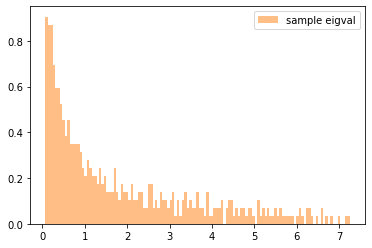

In [44]:
sample_1.hist()

You can optionally set the number of `bins`, which is (an integer part of) $N / 4$ by default; decide whether to have a `legend` (`True` by default); and whether to save the plot to a file (if so, specify a file name in the `savefig` parameter; it is `None` by default, which means to simply display the figure).

### 1.3.3. Example 2

Choose now a VARMA(1, 1) model for $\mathbf{A}$, inverse Wishart model for $\mathbf{C}$, and the Student-t distribution with $5$ degrees of freedom.

In [45]:
sample_2 = SampleEigenvalues(
    method='sandwich',
    N=N,
    C_model='inverse-Wishart',
    kappa=2.,
    T=T,
    A_model='VARMA',
    a_list=[0.8, 0.5],
    b_list=[0.4],
    dist='Student-t',
    df=5
)

In [46]:
sample_2.Y.shape

(500, 2000)

In [47]:
sample_2.E.shape

(500, 500)

In [48]:
sample_2.E_eigval.shape

(500,)

In [49]:
sample_2.E_eigvec.shape

(500, 500)

In [50]:
sample_2.verified_E_eigensystem

True

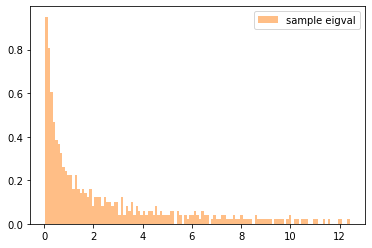

In [51]:
sample_2.hist()

### 1.3.4. Example 3

Choose now an exp-decay model for $\mathbf{A}$, Kumaraswamy model for $\mathbf{C}$, and the Student-t distribution with $3$ degrees of freedom.

In [52]:
sample_3 = SampleEigenvalues(
    method='sandwich',
    N=N,
    C_model='Kumaraswamy',
    a=0.4,
    b=0.7,
    condition_number=5.,
    T=T,
    A_model='exp-decay',
    tau=3.,
    dist='Student-t',
    df=3
)

In [53]:
sample_3.Y.shape

(500, 2000)

In [54]:
sample_3.E.shape

(500, 500)

In [55]:
sample_3.E_eigval.shape

(500,)

In [56]:
sample_3.E_eigvec.shape

(500, 500)

In [57]:
sample_3.verified_E_eigensystem

True

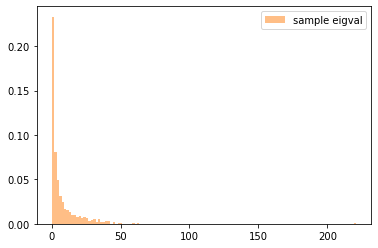

In [58]:
sample_3.hist()

# 2. Shrinkage cleaning of sample eigenvalues

In this section, we will discuss the main module of the library, `shrinkage.rie`, containing classes (especially `LedoitPecheShrinkage` and `VarmaShrinkage`) that allow us to perform _nonlinear shrinkage_, i.e. nonlinear cleaning of the noise present in the sample estimator $\mathbf{E}$ of correlations in the large-dimensional limit.

In [59]:
from shrinkage.rie import LedoitPecheShrinkage, VarmaShrinkage

## 2.1. Introduction

### 2.1.1. Rotationally invariant estimators (RIEs) of correlations - shrinkage

In large-dimensional statistics (recall, both the number of entities $N$ and the number of samples $T$ large and of comparable size, i.e., $q = N/T \sim 1$), the sample estimator $\mathbf{E}$ of correlations is not optimal; its mean squared error (MSE; here known as the _Frobenius norm_) as compared to the "true" (population) correlation matrix $\mathbf{C}$, i.e., $\textrm{Tr} \, (\mathbf{E} - \mathbf{C})^{2}$, does _not_ tend to zero with an increasing number of samples $T$, as it is in standard multivariate statistics ($N$ small compared to $T$). Another way of looking at the problem is to notice that usual statistical estimators have _high variance_ in the large-dimensional limit; the "truth" about the underlying correlations is hidden behind a lot of "noise".

Since estimating correlations is a very common task in diverse areas of science, and often happens in the "big data regime" discussed here (with examples from physics, finance, genomics and bioinformatics, acoustics and signal processing, image processing, cancer research, neuroscience, and others), one is faced with a challenge of constructing _optimal estimators_ $\mathbf{\Xi}$ of correlations, that is, with a lower MSE than the standard sample estimator $\mathbf{E}$. These estimators will have a higher bias than $\mathbf{E}$, but much lower variance, having effectively a lower MSE ([recall](https://en.wikipedia.org/wiki/Bias_of_an_estimator) that MSE = bias$^{2}$ + variance). This is reminiscent of the [James-Stein estimator](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) of multidimensional ($N \geq 3$) mean, which is biased, but has a lower MSE than the standard sample estimator.

One recent approach to the problem is the following: Suppose we do not have any prior information on the eigenvectors of $\mathbf{\Xi}$, no bias in any particular direction in their $N$-dimensional space; then, the only available basis is that of the observed sample estimator $\mathbf{E}$. Let's thus try to construct a MSE-optimal estimator with the same eigenbasis as $\mathbf{E}$, i.e. $\mathbf{u}_{i}$, but with some different eigenvalues $\xi_{i}$:
$$
\mathbf{\Xi} = \sum_{i = 1}^{N} \xi_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} |
$$
In other words, we are "cleaning" the "noise" in the sample eigenvalues $\lambda_{i}$: replacing them by different $\xi_{i}$ so that the MSE of the resulting estimator $\mathbf{\Xi}$ is lower than that of $\mathbf{E}$. This form is called _rotationally invariant estimators_ (RIEs). (The intuition behind this name is that, as mentioned, there is no bias in any particular direction. Furthermore, this Ansatz may be understood in Bayesian language as originating from a prior distribution on $\mathbf{C}$ which is invariant under orthogonal similarity transformations.)

Every such prescription for constructing an estimator with a better MSE is called _shrinkage_; we will observe this visually later on when plotting histograms of both the "noisy" $\lambda_{i}$'s and the "cleaned" $\xi_{i}$'s - the latter will be narrower ("shrunk") as compared to the former, sculpted more tightly around the true underlying eigenvalues of $\mathbf{C}$. We will thus refer to $\xi_{i}$ as _shrunk eigenvalues_.

### 2.1.2. Ledoit-Péché shrinkage and random matrix theory

An optimal set of "cleaned" eigenvalues $\xi_{i}$ is found by minimizing the MSE (Frobenius norm) between $\mathbf{\Xi}$ and $\mathbf{C}$. One does this under an assumption of a certain model for the noise, and then hope that in the large-dimensional limit the result extends to other probability distributions not too dissimilar to the assumed model; similarly like the central limit theorem is derived for Gaussian variables, but then holds for a whole class of distributions, in the limit of a large number of variables. The simplest model of the noise is Gaussian, and in fact, the "sandwich" model discussed above, $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X} \sqrt{\mathbf{A}}$, with $\mathbf{X}$ IID standard normal. In this case, the problem of minimizing the MSE can be solved exactly.

There is however an important observation: the resulting optimal $\xi_{i}$'s depend on the true correlation matrix $\mathbf{C}$; indeed, it is easy to minimize the MSE with a RIE Ansatz:
$$
\xi^{ \textrm{oracle} }_{i} = \langle \mathbf{u}_{i} | \mathbf{C} | \mathbf{u}_{i} \rangle
$$
This is not surprising: we are, after all, considering an error as compared to $\mathbf{C}$, so the solution naturally depends on it. But for this reason, it is hardly useful: $\mathbf{C}$ is unknown in a real-world scenario (and we are doing our best in this library to estimate it!). Since the solution depends on an unknown quantity, it is termed an _oracle estimator_. We will come back later to this topic.

However, it is a known phenomenon that a MSE-optimal estimator may in fact be independent of the parameters being estimated; indeed, miraculously, it can be proven here that in the large-dimensional limit ($N, T \to \infty$ with $q = N/T$ fixed) the dependence on $\mathbf{C}$ disappears, and the "cleaned" eigenvalues $\xi_{i}$ can be expressed solely in terms of observable quantities, namely the sample eigenvalues $\lambda_{i}$, readily estimated from the observed data $\mathbf{Y}$ (this, recall, is performed by the class `SampleEigenvalues`).

This miracle is demonstrated by employing methods of [random matrix theory](https://en.wikipedia.org/wiki/Random_matrix) (RMT). We will not present the derivation, but we do need some definitions. For a random matrix $\mathbf{E}$, say our sample estimator:

- The basic object is the _resolvent_: a matrix function of a complex argument $z$,
  $$
  \mathbf{G}_{ \mathbf{E} } (z) \equiv (z \mathbf{1} - \mathbf{E})^{-1}
  $$
  This looks like a random function, due to the randomness of $\mathbf{E}$, but in the large-$N$ limit, it is self-averaging, i.e. independent of any realization of $\mathbf{E}$, but converging to a deterministic matrix, $\mathbf{G}_{ \mathbf{E} } (z) = \langle \mathbf{G}_{ \mathbf{E} } (z) \rangle$.

- Its normalized trace:
  $$
  G_{ \mathbf{E} } (z) \equiv \frac{1}{N} \textrm{Tr} \, \mathbf{G}_{ \mathbf{E} } (z) = \int \textrm{d} \lambda \rho_{ \mathbf{E} } (\lambda) \frac{1}{z - \lambda}
  $$
  is called the _Stieltjes transform_, and encodes information about the spectrum of $\mathbf{E}$.

- Indeed, a basic characteristic of the spectrum is the _eigenvalue density_, $\rho_{ \mathbf{E} } (\lambda)$. Another characteristic is so-called [_Hilbert transform_](https://en.wikipedia.org/wiki/Hilbert_transform) of the eigenvalues:
  $$
  h_{ \mathbf{E} } (\lambda) \equiv \textrm{pv} \int \textrm{d} \lambda' \rho_{ \mathbf{E} } (\lambda') \frac{1}{\lambda - \lambda'}
  $$
  ("pv" stands for ["principal value"](https://en.wikipedia.org/wiki/Principal_value) of the integral). Now, it turns out that both these quantities are encoded in the Stieltjes transform; indeed, evaluating it close to the real axis produces the Hilbert transform as the real part of the result, and the eigenvalue density as the imaginary part:
  $$
  G_{ \mathbf{E} } (\lambda - \textrm{i} \epsilon) = h_{ \mathbf{E} } (\lambda) + \textrm{i} \pi \rho_{ \mathbf{E} } (\lambda)
  $$
  (where implicitly, $\epsilon \to 0^{+}$).

- A small modification of the resolvent (and Stieltjes transform) is the so-called _M-transform_ (or _moment generating function_), in a matrix form:
  $$
  \mathbf{M}_{ \mathbf{E} } (z) \equiv z \mathbf{G}_{ \mathbf{E} } (z) - 1
  $$
  and, after taking the normalized trace of both sides, a scalar form:
  $$
  M_{ \mathbf{E} } (z) \equiv z G_{ \mathbf{E} } (z) - 1
  $$
  (Its expansion in $1/z$ is comprised of the probabilistic moments of $\mathbf{E}$, hence the name.) We will mainly use the M-transform, rather than the resolvent/Stieltjes transform.

- Now carry out the following procedure: Take the scalar M-transform, $M_{ \mathbf{E} } (z)$, and invert it functionally - this yields the so-called _N-transform_:
  $$
  M_{ \mathbf{E} } ( N_{ \mathbf{E} } (z) ) = N_{ \mathbf{E} } ( M_{ \mathbf{E} } (z) ) = z
  $$
  Further, a numerical inverse of the N-transform is called the $\chi$-_transform_:
  $$
  \chi_{ \mathbf{E} } (z) \equiv \frac{ 1 }{ N_{ \mathbf{E} } (z) }
  $$

Having presented all these definitions, we return to the problem of optimal shrinkage in the case of the "sandwich" model. Let's simplify the model even more by assuming for now $\mathbf{A} = \mathbf{1}$, i.e. no auto-correlations; the model is thus $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X}$, with $\mathbf{X}$ IID standard normal. The MSE-optimal shrunk eigenvalues in this case has been derived - with techniques of random matrix theory - by Olivier Ledoit and Sandrine Péché ([_Eigenvectors of some large sample covariance matrix ensembles_](https://arxiv.org/abs/0911.3010), 2009). As mentioned, a "miracle" happens in that the resulting expression is independent of $\mathbf{C}$, i.e. the parameters being estimated, but fully described by observable quantities; these observables are related to the spectrum of the sample estimator $\mathbf{E}$, and in fact are the eigenvalue density $\rho_{ \mathbf{E} } (\lambda)$ and Hilbert transform $h_{ \mathbf{E} } (\lambda)$, introduced above. For each sample ("noisy") eigenvalue $\lambda_{i}$, denote intermediate variables:
$$
\alpha_{i} \equiv q \left( \lambda_{i} h_{ \mathbf{E} } (\lambda_{i}) - 1 \right) , \qquad \beta_{i} \equiv \pi q \lambda_{i} \rho_{ \mathbf{E} } (\lambda_{i})
$$
(recall, $q = N/T$). The _Ledoit-Péché shrinkage formula_ is then:
$$
\frac{ \xi^{ \textrm{LP} }_{i} }{ \lambda_{i} } = \frac{ 1 }{ (\alpha_{i} + 1)^{2} + \beta_{i}^{2} }
$$
It is implemented in the `LedoitPecheShrinkage` class, outlined below.

### 2.1.3. Epanechnikov kernel estimation

The Ledoit-Péché shrinkage formula depends only on observable quantities, but these quantities still need to be somehow numerically computed from the sample eigenvalues $\xi_{i}$. An ingenious and very simple approach has been recently proposed by Olivier Ledoit and Michael Wolf ([_Analytical nonlinear shrinkage of large-dimensional covariance matrices_](http://www.econ.uzh.ch/static/wp/econwp264.pdf), 2018), in which one approximates the eigenvalue density and Hilbert transform by a sum of [_kernels_](https://en.wikipedia.org/wiki/Kernel_density_estimation), simple functions peaked around each $\lambda_{i}$:
$$
\rho_{ \mathbf{E} } ( \lambda ) = \frac{1}{N} \sum_{i = 1}^{N} \frac{ 1 }{ \mathfrak{b} \lambda_{i} } \mathfrak{r} \left( \frac{ \lambda - \lambda_{i} }{ \mathfrak{b} \lambda_{i} } \right) , \qquad h_{ \mathbf{E} } ( \lambda ) = \frac{1}{N} \sum_{i = 1}^{N} \frac{ 1 }{ \mathfrak{b} \lambda_{i} } \mathfrak{h} \left( \frac{ \lambda - \lambda_{i} }{ \mathfrak{b} \lambda_{i} } \right)
$$
To elucidate the notation: $\mathfrak{r}$ and $\mathfrak{h}$ are kernels used to approximate, respectively, the eigenvalue density and Hilbert transform. For the former, Ledoit and Wolf choose the _Epanechnikov kernel_, essentially a little parabola:
$$
\mathfrak{r} (x) \equiv \frac{ 3 }{ 4 \sqrt{5} } \max \left( 1 - \frac{ x^{2} }{ 5 } , 0 \right)
$$
The latter kernel follows from this one, since the Hilbert transform is an integral of the density, see above; a simple calculation thus gives:
$$
\mathfrak{h} (x) = \frac{3}{10} x - \frac{ 3 }{ 4 \sqrt{5} } \left( 1 - \frac{ x^{2} }{ 5 } \right) \log \left| \frac{ \sqrt{5} - x }{ \sqrt{5} + x } \right|
$$
(with the log-term understood to be zero at $x = \pm \sqrt{5}$). Finally, $\mathfrak{b}$ is a _bandwidth_, a scale factor chosen to yield the best approximation by the kernels; Ledoit and Wolf set it to $\mathfrak{b} = T^{-1/3}$ (recall, $T$ is the number of samples), and we do the same.

To summarize, once the sample eigenvalues $\lambda_{i}$ are retrieved from the data (here with help of the `SampleEigenvalues` class), these simple and explicit formulas provide accurate approximations of the eigenvalue density $\rho_{ \mathbf{E} } ( \lambda )$ and Hilbert transform $h_{ \mathbf{E} } ( \lambda )$, the observables in the Ledoit-Péché shrinkage formula.

### 2.1.4. Shrinkage with auto-correlations

The Ledoit-Péché solution holds, as mentioned, for the "sandwich" model with $\mathbf{A} = \mathbf{1}$, i.e. no auto-correlations. For the full model, $\mathbf{Y} = \sqrt{\mathbf{C}} \mathbf{X} \sqrt{\mathbf{A}}$, a random matrix theory calculation may be carried out, too, and the resulting expression for the MSE-optimal shrunk eigenvalues now involves the $\chi$-transform of the auto-correlation matrix $\mathbf{A}$, as well as the intermediate variables present in the Ledoit-Péché formula, all defined above:
$$
\frac{ \xi_{i} }{ \lambda_{i} } = \frac{ \textrm{Im} \, \chi_{ \mathbf{A} } (u_{i}) }{ \textrm{Im} \, u_{i} } , \qquad u_{i} \equiv \alpha_{i} + \textrm{i} \beta_{i}
$$
The logic here is the following: We need to assume some model of auto-correlations, some matrix $\mathbf{A}$; for this model, we should be able to calculate the $\chi$-transform, $\chi_{ \mathbf{A} } (z)$; once this function is available, we compute the shrunk eigenvalues from the Ledoit-Péché variables $\alpha_{i}$ and $\beta_{i}$.

One might protest that $\mathbf{A}$ should in principle be estimated from the data itself. However, this here approach again demonstrates the power of an "effective" description: we choose some tractable model of auto-correlations, with some parameters that we eventually _fit_ to data; what matters is that the final estimator even better reflects the truth of the underlying $\mathbf{C}$.

A broad family of models for $\mathbf{A}$, which are both tractable and inclusive of a wide range behaviors, is the [VARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) class, see above. We have calculated the $\chi$-transform of $\mathbf{A}$ for several sub-models here, namely VMA(1), VAR(1), VARMA(1, 1), VMA(2), and VAR(2); see below.

## 2.2. Ledoit-Péché shrinkage (`LedoitPecheShrinkage` class)

The Ledoit-Péché formula (which, recall, holds for the "sandwich" model with no auto-correlations) is implemented in the `LedoitPecheShrinkage` class in the `shrinkage.rie` module. Moreover, this will be a parent class of various other nonlinear shrinkage methods, valid for particular models of $\mathbf{A}$; for instance, the `VarmaShrinkage` class, which implements formulas for VARMA auto-correlations.

We instantiate the class with parameters:

- `lambdas`: an array of $N$ sample eigenvalues $\lambda_{i}$;

- `T`: the number of samples.

Then, $N$ will be accessible through the `N` attribute, and $q = N/T$ through `q`; also, the `name` attribute is set to `'Ledoit-Peche'`. By this mere instantiation, it performs:

- Epanechnikov kernel estimation of the density $\rho_{ \mathbf{E} } (\lambda)$ and Hilbert transform $h_{ \mathbf{E} } (\lambda)$ of the sample eigenvalues $\lambda_{i}$; they are then available in the attributes `lambdas_kernel_density` and `lambdas_kernel_Hilbert`; the kernel bandwidth is set to $\mathfrak{b} = T^{-1/3}$, and resides in `bandwidth` (and can be changed here);

- calculation of the Ledoit-Péché intermediate variables $\alpha_{i}$, $\beta_{i}$, and $u_{i}$, as well as the actual shrunk eigenvalues, $\xi^{ \textrm{LP} }_{i}$; they reside in the attributes `alpha`, `beta`, `u_range`, `xi_LP`;

- since we now possess the Ledoit-Péché shrunk eigenvalues, we may well perform Epanechnikov kernel estimation of their density $\rho_{ \mathbf{\Xi} } (\xi)$ and Hilbert transform $h_{ \mathbf{\Xi} } (\xi)$; attributes `xi_LP_kernel_density` and `xi_LP_kernel_Hilbert`.

### 2.2.1. Instantiation of the class

First, simulate a data matrix $\mathbf{Y}$ from the "sandwich" model, with $\mathbf{C}$ consisting of two clustered eigenvalues, and no auto-correlations (i.e., the regime to which the Ledoit-Péché formula applies).

In [60]:
N = 500
T = 1000

In [61]:
sample_0 = SampleEigenvalues(
    method='sandwich',
    N=N,
    C_model='clusters',
    f_list=[0.5],
    e_list=[1., 3.],
    T=T
)

Instantiate the Ledoit-Péché shrinkage class, with the sample eigenvalues from the simulation above:

In [62]:
shrinkage_0 = LedoitPecheShrinkage(
    lambdas=sample_0.E_eigval,
    T=sample_0.T
)

shrinkage_0.name

'Ledoit-Peche'

Kernel estimates for $\mathbf{E}$:

In [63]:
shrinkage_0.lambdas_kernel_density.shape

(500,)

In [64]:
shrinkage_0.lambdas_kernel_Hilbert.shape

(500,)

The Ledoit-Péché intermediate variables and the final result:

In [65]:
shrinkage_0.alpha.shape

(500,)

In [66]:
shrinkage_0.beta.shape

(500,)

In [67]:
shrinkage_0.u_range.shape

(500,)

In [68]:
shrinkage_0.xi_LP.shape

(500,)

Kernel estimates for $\mathbf{\Xi}$:

In [69]:
shrinkage_0.xi_LP_kernel_density.shape

(500,)

In [70]:
shrinkage_0.xi_LP_kernel_Hilbert.shape

(500,)

### 2.2.2. Calculating the shrunk eigenvalues - prediction

Technical note: Both this class, and its every child, will have a key method called `predict`; its role is to calculate the shrunk eigenvalues $\xi_{i}$ (residing in the attribute `xi`). In other words, whenever writing a new shrinkage class, make sure the actual calculation of $\xi_{i}$ is done in `predict`.

Here all this method does is a simple substitution, $\xi_{i} = \xi^{ \textrm{LP} }_{i}$, as the actual solution has already been found during the instantiation. The reason is that $\xi^{ \textrm{LP} }_{i}$, as well as the intermediate variables, $\alpha_{i}$, $\beta_{i}$, $u_{i}$, will _also_ be needed in child classes, for calculations of shrunk eigenvalues under non-trivial $\mathbf{A}$; thus, we need them separately from the `LedoitPecheShrinkage`'s `predict` method.

In [71]:
shrinkage_0.predict()

In [72]:
shrinkage_0.xi.shape

(500,)

In [73]:
np.allclose(shrinkage_0.xi, shrinkage_0.xi_LP)

True

### 2.2.3. Plotting capabilities

The `LedoitPecheShrinkage` class has two plotting methods, `plot` and `hist`. They will really shine for its child classes, when we are able to visually compare $\xi_{i}$ and $\xi^{ \textrm{LP} }_{i}$, as well as investigate multiple branches of the solution $\xi_{i}$. But for now, let's demonstrate their basic usage.

#### `plot`

Having calculated the "cleaned"/"shrunk" eigenvalues $\xi_{i}$ from the "noisy" ones $\lambda_{i}$, we may plot the two sets in various ways. One is a simple plot of $\lambda_{i}$ on the horizontal axis, and $\xi_{i}$ on the vertical one, produced by the `plot` method.

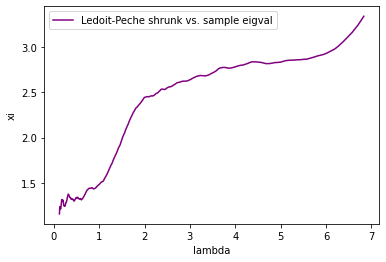

In [74]:
shrinkage_0.plot()

One may also optionally set arguments `xlim`, `ylim` (either a two-element tuple; which range of the respective axis to show), `legend` (Boolean; whether to show a legend, `True` by default), `savefig` (a file name to save the graph).

#### `hist`

A second type of a plot we may produce is a histogram (the `hist` method), in which we may show any combination of the nine plots:

- histograms of $\lambda_{i}$, of $\xi_{i}$, or of $\xi^{\textrm{LP}}_{i}$,

- the (Epanechnikov-kernel-estimated) densities of these three sets of eigenvalues,

- as well as their (so-estimated) Hilbert transforms.

(An attentive reader will have noticed that we haven't yet performed kernel estimation of the density and Hilbert transform of the $\xi_{i}$'s, only of the $\lambda_{i}$'s and the $\xi^{\textrm{LP}}_{i}$'s; this is done automatically when we attempt to plot these estimates here, via the "private" method `_calculate_epanechnikov_estimates` with the argument `eigval='xi'`. They're then accessible through the attributes `xi_kernel_density` and `xi_kernel_Hilbert`.)

For instance:

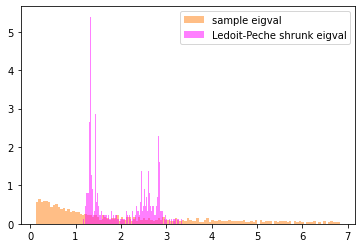

In [75]:
shrinkage_0.hist(
    show_lambdas=True,
    show_xi=True
)

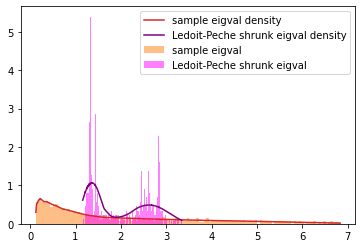

In [76]:
shrinkage_0.hist(
    show_lambdas=True,
    show_xi=True,
    show_lambdas_density=True,
    show_xi_density=True
)

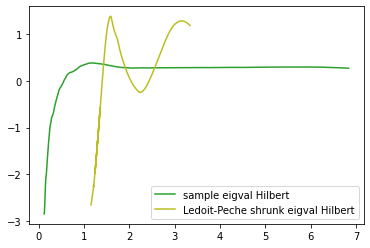

In [77]:
shrinkage_0.hist(
    show_lambdas_Hilbert=True,
    show_xi_Hilbert=True
)

One may again optionally set arguments `xlim`, `ylim`, `legend`, `savefig`, plus also `bins` (integer part of $N/4$ by default).

We now have:

In [78]:
shrinkage_0.xi_kernel_density.shape

(500,)

In [79]:
shrinkage_0.xi_kernel_Hilbert.shape

(500,)

## 2.3. VARMA shrinkage (`VarmaShrinkage` class)

For a non-trivial structure of $\mathbf{A}$ in the "sandwich" model, we need to construct a child class of `LedoitPecheShrinkage` which is able to calculate the $\chi$-transform of $\mathbf{A}$, and thus the shrunk eigenvalues, according to the main formula, which we recall:
$$
\frac{ \xi_{i} }{ \lambda_{i} } = \frac{ \textrm{Im} \, \chi_{ \mathbf{A} } (u_{i}) }{ \textrm{Im} \, u_{i} } , \qquad u_{i} \equiv \alpha_{i} + \textrm{i} \beta_{i}
$$
For VARMA-type auto-correlations, this class is `VarmaShrinkage`.

### 2.3.1. Instantiation of the class

First, simulate $\mathbf{Y}$ from the "sandwich" model, with $\mathbf{C}$ consisting of two clustered eigenvalues, and $\mathbf{A}$ exp-decay with auto-correlation time $\tau = 3$.

In [80]:
N = 500
T = 1000

In [81]:
sample_1 = SampleEigenvalues(
    method='sandwich',
    N=N,
    C_model='clusters',
    f_list=[0.5],
    e_list=[1., 3.],
    T=T,
    A_model='exp-decay',
    tau=3.
)

We instantiate an object of `VarmaShrinkage` same as before, with `lambdas` (an array of $\lambda_{i}$'s), and `T` (the number of samples, $T$). What it does is only instantiates the parent class, `LedoitPecheShrinkage`, therefore computing the Epanechnikov kernel estimates and the Ledoit-Péché variables, as described above.

In [82]:
shrinkage_1 = VarmaShrinkage(
    lambdas=sample_1.E_eigval,
    T=sample_1.T
)

shrinkage_1.name

'Ledoit-Peche'

### 2.3.2. Setting (and getting) VARMA parameters

We however want to perform shrinkage with VARMA shrinkage, not Ledoit-Péché shrinkage; to this end, we need to set VARMA parameter values, via the `set_params` method. These parameters are:

- either an `a_list`, containing $(r_{2} + 1)$ "MA" parameters, $a_{0}, a_{1}, \ldots, a_{ r_{2} }$, and a `b_list`, containing $r_{1}$ "AR" parameters, $b_{1}, \ldots, b_{ r_{1} }$;

- or $\tau$, which means we want a particular VAR(1) model, with $a_{0}$, $b_{1}$ related to $\tau$ by a formula above; this is a model with simple exponentially-decaying auto-correlations.

Note: We emphasize that these parameters should in principle be thought of as "trainable", found by some fitting procedure based on the observed sample eigenvalues; in this section, however, we provide these trainable weights by hand. In effect, we're now learning only how to make _predictions_ for fixed parameters, not yet any _fitting_.

We have simulated $\mathbf{Y}$ from an exp-decay model of $\mathbf{A}$, with $\tau = 3$, and let's use this same model now in the shrinkage procedure. But again, in a real-world scenario, such a model for $\mathbf{A}$ would be unknown; we will see that then a philosophy should be to pick some model of shrinkage, e.g. exp-decay like here, and _fit_ $\tau$ to the observed data.

In [83]:
shrinkage_1.set_params(
    tau=sample_1.auto_covariance.tau
)

shrinkage_1.name

'VAR(1)'

At any moment we may retrieve the paramaters of a given VARMA shrinkage model via the `get_params` method:

In [84]:
shrinkage_1.get_params()

{'a_list': array([0.69755493]), 'b_list': array([0.71653131])}

Note that we have an `a_list` and `b_list` here; indeed, the exp-decay model is a particular case of VAR(1).

### 2.3.3. The M-transform of the auto-correlation matrix

Having now instantiated a particular VARMA shrinkage, here VAR(1) shrinkage, we get access to:

- the auto-correlation matrix $\mathbf{A}$, via the attribute `A`,

- its scalar M-transform, $M_{ \mathbf{A} } (z)$, via the method `calculate_M_transform_A`, called with a real and imaginary parts of $z$.

Technical note: The class `VarmaShrinkage` is a child not only of `LedoitPecheShrinkage`, but also of `Varma` (from `shrinkage.varma`), and the latter provides these functionalities.

In [85]:
shrinkage_1.A.shape

(1000, 1000)

In [86]:
shrinkage_1.calculate_M_transform_A(z_re=0.2, z_im=0.3)

(-0.485246395434082-0.5740889688734291j)

### 2.3.4. Calculating the shrunk eigenvalues - prediction

Now, one fundamental method of each shrinkage class is `predict`, which performs the "cleaning" - the move from the "noisy" $\lambda_{i}$ to the "clean"/"shrunk" $\xi_{i}$.

In [87]:
shrinkage_1.predict()

The shrunk eigenvalues then reside in the `xi` attribute.

In [88]:
shrinkage_1.xi.shape

(500,)

Prediction in the VARMA case amounts to two operations:

- First, solving an equation $M_{\mathbf{A}}(1 / \chi) = u$ in variable $\chi$, for given complex $u$, where recall $M_{\mathbf{A}}(\cdot)$ is the M-transform of the auto-correlation matrix $\mathbf{A}$; in other words, $\chi = \chi_{\mathbf{A}}(u) = 1 / N_{\mathbf{A}}(u)$, making use of the $\chi$-transform and N-transform of $\mathbf{A}$, the latter being the functional inverse of the M-transform. For the particular models we consider here, which for the VARMA class are VMA(1), VAR(1), VARMA(1, 1), VMA(2), VAR(2), this turns out to be a polynomial equation in $\chi$, $P(\chi) = 0$, of degree, respectively, 2, 2, 3, 5, 5, with coefficients depending on $u$, as well as the pertinent VARMA parameters (e.g. $a_{0}$, $b_{1}$, $b_{2}$ for VAR(2)). These five polynomials $P$ are hard-coded in text files residing in the subdirectory `chi_equations`, and then in a further subdirectory corresponding to the model, e.g. the equation for VAR(2) is in the subdirectory `var_2`, and then in the file `pol.txt`. If you want to recreate these text files, run the `varma.py` script (`py -m varma` from the `shrinkage` directory).

- Second, for these polynomial equations we get multiple solutions at each point $\lambda_{i}$, that is multiple "branches", collected in the attribute `chi_roots_branch`; the number of branches resides in `n_branches`. Consequently, we need to select the "right" branch; to this end, one simply needs to calculate $M_{\mathbf{A}}(1 / \chi)$ on each branch (it's stored in the `M_of_N_branch` attribute), and select the one where this quantity is equal to $u$ (which in turn is stored in the `u_range` attribute, as we already know).

Recall that the relation of $u_{i}$ to $\lambda_{i}$ is $u_{i} = \alpha_{i} + \textrm{i} \beta_{i}$, where we've defined above the Ledoit-Péché intermediate variables. Then, if we solve for $\chi_{i}$, and choose the correct branch, the final shrunk eigenvalue is given by the fundamental formula:
$$
\xi_{i} = \frac{ \lambda_{i} }{ \beta_{i} } \textrm{Im} \chi_{i}
$$
All the branches of $\xi_{i}$ reside in the `xi_branch` attribute.

All these "branch" attributes are of shape `(n_branches, N)`. After selecting the right branch, we have length-`N` array attributes, `chi_roots` and `xi`.

For the present VAR(1) case, we have a second degree polynomial, and so two branches:

In [89]:
shrinkage_1.n_branches

2

In [90]:
shrinkage_1.chi_roots_branch[0].shape

(500,)

In [91]:
shrinkage_1.chi_roots_branch[1].shape

(500,)

In [92]:
shrinkage_1.xi_branch[0].shape

(500,)

In [93]:
shrinkage_1.xi_branch[1].shape

(500,)

In [94]:
shrinkage_1.M_of_N_branch.shape

(2, 500)

The correct branch, as mentioned, is in:

In [95]:
shrinkage_1.xi.shape

(500,)

In [96]:
shrinkage_1.chi_roots.shape

(500,)

### 2.3.5. Prediction on a batch

We may perform prediction only on a subset of indices $i$ of $\lambda_{i}$.

In [97]:
shrinkage_1.predict(
    batch_idx=[5, 18, 177, 352, 419]
)

In [98]:
shrinkage_1.xi.shape

(5,)

In [99]:
shrinkage_1.chi_roots.shape

(5,)

We now have attributes available that record the batch size and the batch indices:

In [100]:
shrinkage_1.N_batch

5

In [101]:
shrinkage_1.batch_idx

[5, 18, 177, 352, 419]

We emphasize also that when we make a prediction, the resulting shrunk eigenvalues aren't returned, rather they're every time recorded in the attribute `xi`.

### 2.3.6. Prediction with gradients

We may also optionally (`calculate_grads=True`), alongside the calculation of $\chi_{i}$ and $\xi_{i}$, compute the _gradients_ $\partial \chi_{i} / \partial \theta$ and $\partial \xi_{i} / \partial \theta$ for every VARMA model parameter $\theta$, e.g. $a_{0}$, $a_{1}$, $b_{1}$, etc. To this end, we retrieve appropriate text files, e.g. `grad_a0.txt` from the `var_1` folder, which would be the gradient w.r.t. $a_{0}$ of the polynomial $P$ (residing, as we recall, in the `pol.txt` file). Every model folder, like `var_1`, contains all such gradient files, plus `grad_chi.txt` for the gradient w.r.t. $\chi$. Now, differentiating the basic equation $P(u, \chi; \{ \theta \}) = 0$, solved by $\chi = \chi(u; \{ \theta \})$, w.r.t. each parameter $\theta$, relates the gradients we're aiming to compute with the gradients recorded in the text files:
$$
\frac{ \partial \chi }{ \partial \theta } = - \frac{ \frac{ \partial P }{ \partial \theta } }{ \frac{ \partial P }{ \partial \chi } }
$$
(If one wishes more reassurance, one may solve the relevant quadratic equation for the VAR(1) case, calculate its derivative on the l.h.s., and compare with the r.h.s. - they will agree.) Once this is calculated, the more relevant gradient of the shrunk eigenvalue w.r.t. every VARMA model parameter is:
$$
\frac{ \partial \xi }{ \partial \theta } = \frac{ \lambda }{ \beta } \textrm{Im} \frac{ \partial \chi }{ \partial \theta }
$$
These two gradients reside in the `chi_grads` and `xi_grads` attributes, which are dictionaries, with keys being string representations of the VARMA parameter names, and the values being arrays of length `N` (or `N_batch`), corresponding to the index $i$.

In [102]:
shrinkage_1.predict(calculate_grads=True)

In [103]:
shrinkage_1.xi.shape

(500,)

In [104]:
shrinkage_1.chi_roots.shape

(500,)

In [105]:
shrinkage_1.chi_grads.keys()

dict_keys(['a0', 'b1'])

In [106]:
len(shrinkage_1.chi_grads['a0'])

500

In [107]:
shrinkage_1.xi_grads.keys()

dict_keys(['a0', 'b1'])

In [108]:
shrinkage_1.xi_grads['a0'].shape

(500,)

We may check these gradients numerically by slightly modifying a VARMA parameter, predicting the new shrunk eigenvalues, and seeing if they changed as compared to the old ones by the gradient:

In [109]:
from copy import deepcopy

In [110]:
shrinkage_1.predict()
xi_1 = shrinkage_1.xi.copy()

eps =1e-4

params_dict_new = deepcopy(shrinkage_1.get_params())
params_dict_new['a_list'][0] += eps

shrinkage_1_eps = VarmaShrinkage(
    lambdas=sample_1.E_eigval,
    T=sample_1.T
)
shrinkage_1_eps.set_params(**params_dict_new)
shrinkage_1_eps.predict()

xi_1_eps = shrinkage_1_eps.xi.copy()

np.allclose((xi_1_eps - xi_1)/eps, shrinkage_1.xi_grads['a0'], atol=1e-2, rtol=1e-2)

True

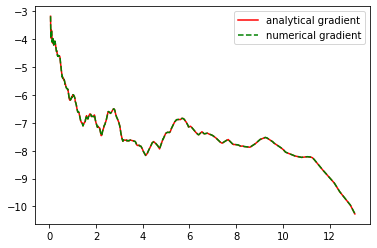

In [111]:
plt.plot(sample_1.E_eigval, shrinkage_1.xi_grads['a0'], 'r', label='analytical gradient')
plt.plot(sample_1.E_eigval, (xi_1_eps - xi_1)/eps, 'g--', label='numerical gradient')
plt.legend()
plt.show()

### 2.3.7. Plotting capabilities

The plotting methods, `plot` and `hist`, are part of the parent class, `LedoitPecheShrinkage`, but for shrinkage with non-trivial $\mathbf{A}$, they allow for broader capabilities.

#### `plot`

Recall that `plot` shows $\lambda_{i}$ on the horizontal axis, and $\xi_{i}$ on the vertical axis.

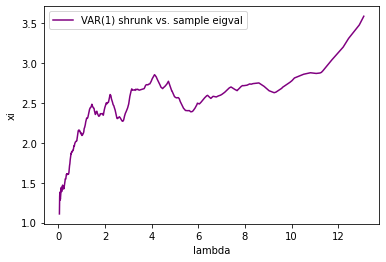

In [112]:
shrinkage_1.plot()

For these more complicated shrinkage models, there are typically multiple branches of solutions for $\xi_{i}$. We may use `plot` to show all of the branches together (`branch='all'`), or perhaps some select ones by setting the `branch` argument of `plot` to a string with a branch number, e.g. `'2'`, or a list of such strings, e.g. `['1', '2']`, where the convention is that branches are one-indexed, so 1, 2, 3, etc.

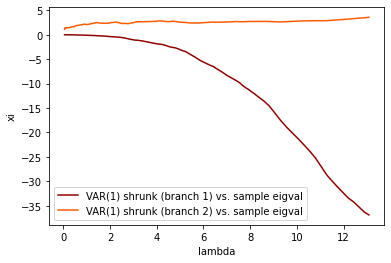

In [113]:
shrinkage_1.plot(branch='all')

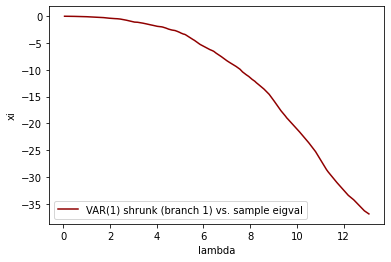

In [114]:
shrinkage_1.plot(branch='1')

#### `hist`

The `hist` method, recall, shows any select combination of the nine plots:

- histograms of $\lambda_{i}$, of $\xi_{i}$, or of $\xi^{\textrm{LP}}_{i}$,

- the (Epanechnikov-kernel-estimated) densities of these three sets of eigenvalues,

- as well as their (so-estimated) Hilbert transforms.

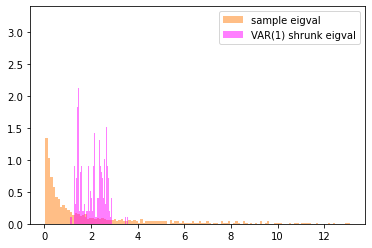

In [116]:
shrinkage_1.hist(
    show_lambdas=True,
    show_xi=True
)

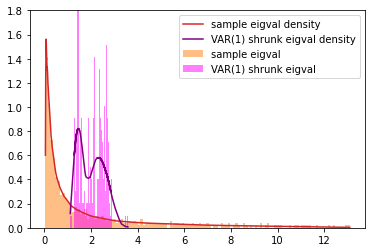

In [120]:
shrinkage_1.hist(
    show_lambdas=True,
    show_xi=True,
    show_lambdas_density=True,
    show_xi_density=True,
    ylim=(0, 1.8),
    savefig='figures\C_clusters_2_Gaussian_VAR_1_exp_decay_hist.png'
)

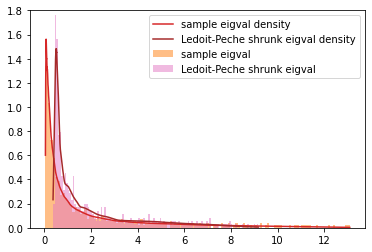

In [121]:
shrinkage_1.hist(
    show_lambdas=True,
    show_xi_LP=True,
    show_lambdas_density=True,
    show_xi_LP_density=True,
    ylim=(0, 1.8),
    savefig='figures\C_clusters_2_Gaussian_VAR_1_exp_decay_hist_LP.png'
)

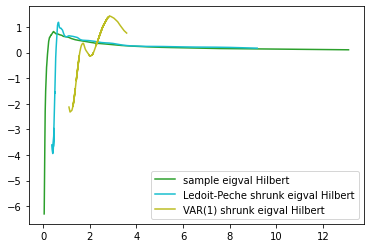

In [122]:
shrinkage_1.hist(
    show_lambdas_Hilbert=True,
    show_xi_Hilbert=True,
    show_xi_LP_Hilbert=True
)

## 2.4. Fitting to oracle eigenvalues

### 2.4.1. RIEs and Frobenius ratio (`SampleEigenvalues` class)

#### RIEs

The main goal of this library is calculating shrunk eigenvalues $\xi_{i}$. If we take a step back, recall that they are the eigenvalues of a rotationally invariant estimator (RIE), $\mathbf{\Xi} = \sum_{i = 1}^{N} \xi_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} | = \mathbf{U} \, \textrm{diag}(\mathbf{\xi}) \, \mathbf{U}^{\top}$, with the same eigenvectors as the sample estimator $\mathbf{E}$. Since these eigenvectors are part of the `SampleEigenvalues` class (the `E_eigvec` attribute), we will also in this class have a method to compute a RIE from a given set of eigenvalues $\mathbf{x}$, i.e. an expression $\sum_{i = 1}^{N} x_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} |$.

For instance, compute a RIE with eigenvalues equal to the shrunk eigenvalues $\xi_{i}$:

In [123]:
sample_1.rie(x=shrinkage_1.xi).shape

(500, 500)

#### Frobenius ratio

In the case when we've simulated our dataset, like we just did, and we know the "true" correlation matrix $\mathbf{C}$, we have access to the method `frobenius_ratio`, with an argument `x`. It first takes the attribute `frobenius_C_E`, which equals the Frobenius norm (i.e., RMSE) of the difference $(\mathbf{E} - \mathbf{C})$ between the sample and population correlation matrices; it calculates the Frobenius norm of the difference $(\mathbf{\Xi}(\mathbf{x}) - \mathbf{C})$; finally, it returns the ratio of the latter to the former. This ratio is a measure of how much better the RIE with eigenvalues `x` estimates the true correlation matrix as compared to the sample estimator. (And the Frobenius norm squared itself of a matrix $\mathbf{W}$ is defined as $\textrm{Tr} \, \mathbf{W} \mathbf{W}^{\top}$.)

For instance:

In [124]:
sample_1.frobenius_ratio(x=shrinkage_1.xi)

0.12158021791412352

In [125]:
sample_1.frobenius_C_E

3188.17139996844

For comparison, we may calculate the same ratio for the Ledoit-Péché shrunk eigenvalues $\xi^{\textrm{LP}}_{i}$; we know that this shrinkage method is valid only when there are no auto-correlations, and so the Frobenius ratio should be worse (higher) than for our shrinkage, which makes use of the VARMA auto-correlation structure. Notice that we don't need to create a `LedoitPecheShrinkage` object specifically, as our child class also performed this shrinkage internally, as an intermediate step, and the Ledoit-Péché shrunk eigenvalues reside in the `xi_LP` attribute.

In [126]:
sample_1.frobenius_ratio(x=shrinkage_1.xi_LP)

0.5310882797604631

We've already observed visually how this "incorrect" shrinkage works, that it produces a wider (hence, less cleaned) histogram.

### 2.4.2. The oracle estimator (`SampleEigenvalues` class)

Recall the philosophy of RIEs we have outlined above: Our goal is to minimize an error (here: MSE, or "Frobenius norm", as it is called in the context of matrices) between the true correlation matrix $\mathbf{C}$, which is unknown, and its estimator $\mathbf{\Xi}$. We choose a particular Ansatz, $\mathbf{\Xi} = \sum_{i = 1}^{N} \xi_{i} | \mathbf{u}_{i} \rangle \langle \mathbf{u}_{i} |$, termed a "rotationally invariant estimator" (RIE), which means that it has the same eigenvectors $\mathbf{u}_{i}$ as the sample estimator $\mathbf{E}$, but some new eigenvalues, $\xi_{i}$, to be determined via said minimization process. Indeed, these "shrunk eigenvalues" can be found in a straightforward way, as the problem is quadratic, $\xi^{ \textrm{oracle} }_{i} = \langle \mathbf{u}_{i} | \mathbf{C} | \mathbf{u}_{i} \rangle$. In this form, they are referred to as "oracle eigenvalues", since they require oracular insight into the underlying $\mathbf{C}$. Miraculously, however, in the large-dimensional limit ($N, T \to \infty$, with $q = N/T$ fixed), it is shown that this formula can be entirely expressed through observable quantities, that is, dependent on the observed sample eigenvalues $\lambda_{i}$. This is the broad topic of "shrinkage", and we have discussed several forms of it.

On another note, the oracle eigenvalues can be estimated with an altogether different procedure, cf. section 8.2 of a paper by Joël Bun, Jean-Philippe Bouchaud, Marc Potters ([Cleaning large correlation matrices: tools from random matrix theory](https://arxiv.org/abs/1610.08104), 2016), which we briefly describe.

- We take the total number of samples we have, $T_{ \textrm{total} }$, and divide it into two parts: an "in-sample" period of length $T$, and an "out-of-sample" period, of length $(T_{ \textrm{total} } - T)$. Notice that everywhere so far we have only used the initial $T$ samples out of $T_{ \textrm{total} }$; this here is the only place where we need also the latter "out-of-sample" part. This latter part we further divide into $n$ sub-periods ("folds") of length $T_{ \textrm{out} }$, so that $n = \lfloor (T_{ \textrm{total} } - T) / T_{ \textrm{out} } \rfloor$. In the one-indexed notation here, the in-sample period has temporal indices $1, \ldots, T$, then a $\mu$-th fold ($\mu = 0, \ldots, n - 1$) has the starting index of $t_{ \mu } = T + \mu T_{ \textrm{out} } + 1$.

- The idea is to imagine that we have just observed the "in-sample" period, and estimated on it the sample correlation $\mathbf{E}$. Indeed, this is precisely what the `SampleEigenvalues` class does: $\mathbf{E} = \frac{1}{T} \mathbf{Y}_{ \textrm{trunc} } \mathbf{Y}_{ \textrm{trunc} }^{\top}$ (the `E` attribute), where $\mathbf{Y}_{ \textrm{trunc} }$ is the $N \times T$ part of $\mathbf{Y}$. The remaining "out-of-sample" period is as of yet in the future.

- Think now of $Y_{i t}$ as a financial asset $i$ at time $t$. We now form a portfolio of these assets; in fact, we form $N$ portfolios which, by definition, have weights given by the (in-sample) eigenvectors $\mathbf{u}_{i}$ of $\mathbf{E}$. Such an $i$-th portfolio has therefore value at time $t$ of
  $$
  \pi_{i t} = \sum_{j = 1}^{N} [ \mathbf{u}_{i} ]_{j} Y_{j t} , \qquad \textrm{i.e.} \qquad \pi_{i} = \langle \mathbf{u}_{i} | \mathbf{Y}
  $$

- We now want to estimate a _risk_ of every such portfolio. In other words, how much variance it has, but measured not on the in-sample perdiod we have used to construct it, but on the future out-of-sample period - a _realized risk_. Such an out-of-sample risk on a $\mu$-th fold (starting, recall, at $t_{ \mu }$, and having length $T_{ \textrm{out} }$) is,
  $$
  \mathcal{R}_{ i, \mu }^{2} = \frac{ 1 }{ T_{ \textrm{out} } } \sum_{ t = t_{ \mu } }^{ t_{ \mu } + T_{ \textrm{out} } - 1 } \pi_{i t}^{2} = \langle \mathbf{u}_{i} | \mathbf{E}_{ \mu } | \mathbf{u}_{i} \rangle , \qquad \textrm{where} \qquad \mathbf{E}_{ \mu } \equiv \frac{ 1 }{ T_{ \textrm{out} } } \mathbf{Y}_{ \mu } \mathbf{Y}_{ \mu }^{\top}
  $$
  We assume standardized assets, and denote by $\mathbf{Y}_{ \mu }$ the temporal part of $\mathbf{Y}$ that falls into the $\mu$-th fold.

- Finally, average this variance of the $i$-th portfolio on the $\mu$-th fold over all the folds. This average realized risk of the $i$-the sample eigenportolio is precisely an estimate of the $i$-th oracle eigenvalue,
  $$
  \xi^{ \textrm{oracle} }_{i} \approx \frac{1}{n} \sum_{\mu = 0}^{n - 1} \mathcal{R}_{ i, \mu }^{2} = \langle \mathbf{u}_{i} | \mathbf{E}_{ \textrm{oos} } | \mathbf{u}_{i} \rangle , \qquad \textrm{where} \qquad \mathbf{E}_{ \textrm{oos} } \equiv \frac{1}{n} \sum_{\mu = 0}^{n - 1} \mathbf{E}_{ \mu }
  $$

From the point of view of program design, this out-of-sample procedure is a part of the `SampleEigenvalues` class:

- either we call the `calculate_oracle` method on an instance of the class, providing it with a `T_out` parameter;

- or we instantiate the class in the first place with this parameter, and the said method is called automatically.

The resulting number of folds then resides in the attribute `n`. Crucially, the out-of-sample estimate of the oracle eigenvalues becomes available in the attribute `xi_oracle`.

In [127]:
sample_1.calculate_oracle(T_out=100)

In [128]:
sample_1.n

10

In [129]:
sample_1.xi_oracle.shape

(500,)

Let's look at the Frobenius ratio for this set of out-of-sample oracle eigenvalues:

In [130]:
sample_1.frobenius_ratio(x=sample_1.xi_oracle)

0.12347741395018504

Notice that this Frobenius ratio is very similar to the one we got from our exp-decay shrinkage $\xi_{i}$; and much lower than the one from Ledoit-Péché shrinkage.

### 2.4.3. `plot_with_oracle` method (`LedoitPecheShrinkage` class)

Let's move back to the `LedoitPecheShrinkage` (parent) class. We have already discussed the `plot` method, with which we plot the shrunk $\xi_{i}$ versus the noisy $\lambda_{i}$. The `plot_with_oracle` method is similar to it, but more focused: instead of the ability to show various branches of the solutions of $\xi_{i}$ (which is useful for investigative purposes), we now can:

- show additionally the Ledoit-Péché $\xi^{ \textrm{LP} }_{i}$ versus $\lambda_{i}$ (`show_LP=True`);

- crucially, show a scatter plot of the out-of-sample oracle eigenvalues $\xi^{ \textrm{oracle} }_{i}$ versus $\lambda_{i}$ (which we must provide via the `xi_oracle` argument; and which are calculated in the `SampleEigenvalues` class as outlined above).

(It has the usual options, `xlim` and `ylim`; `legend`; `savefig`.)

It may be said that the closer our shrinkage $\xi_{i}$ reflects these out-of-sample oracle eigenvalues, the better. We see how in the situation we have put in an exponentially-decaying auto-correlations to $\mathbf{Y}$, and we have used an exp-decay shrinkage with the correct $\tau$, our result follows very closely the oracle scatter plot (in contradistinction to the Ledoit-Péché shrinkage).

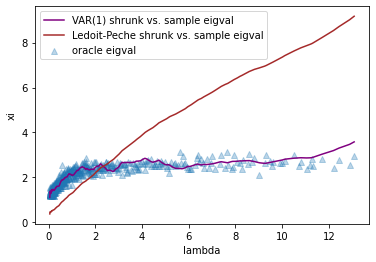

In [131]:
shrinkage_1.plot_with_oracle(
    xi_oracle=sample_1.xi_oracle,
    show_LP=True,
    savefig='figures\C_clusters_2_Gaussian_VAR_1_exp_decay_oracle.png'
)

### 2.4.4. Fitting shrinkage parameters to the oracle eigenvalues (`VarmaShrinkage` class)

When we defined a shrinkage model above, we "cheated" in that we provided it with the VARMA parameters precisely equal to the ones we'd used to generate the data (here: the auto-correlation time $\tau$) - and this information is in principle unknown. Furthermore, it turns out that if we generate data with some VARMA parameters, but a _non-Gaussian_ distribution (e.g. Student-t), even "cheating" this way does not guarantee an optimal performance: the Frobenius ratio may be worse than even Ledoit-Péché shrinkage. Indeed, the shrinkage formula assumes a Gaussian basin of distributions. This matter is only more pronounced for real-world data, when we don't know the underlying data-generating model, so can't even "cheat".

To alleviate this difficulty, in this section we'll look at the problem from a different angle. Having some sample eigenvalues $\lambda_{i}$, be it generated synthetically according to some model (which suppose is unknown to us), or coming from a real-world dataset, we are at a loss as how to choose a shrinkage model. But what we can do is:

- choose a _family_ of shrinkage models, say `VarmaShrinkage` of given $(r_{1}, r_{2})$, and a _grid_ of parameters of this family; the `grid` should be a list of dictionaries, each dictionary corresponding to the kwargs in the shrinkage model;

- then calculate the shrunk eigenvalues $\xi_{i}$ for every parameter set from the grid, from the "noisy" $\lambda_{i}$'s;

- on the other hand, calculate the oracle eigenvalues $\xi^{ \textrm{oracle} }_{i}$ from the dataset via the out-of-sample procedure;

- for every parameter set from the grid, then, compute some given error function between $\xi_{i}$ and $\xi^{ \textrm{oracle} }_{i}$, and choose this set of parameters for which this error is minimal; the error may be e.g. `loss='mse'`.

This procedure is accomplished by the `fit` method, with `optimizer='brute'`. In other words, while so far we've done only _prediction_, with parameters conjured out of thin air, now we focus on _fitting_; and we do so by a simple brute-force search of a minimum. Our class supports other optimizers, such as gradient descent, but brute force turns out to be quite effective, especially when fitting a one-dimensional exp-decay case, i.e., VAR(1) shrinkage with $a_{0} = \sqrt{1 - b_{1}^{2}}$ and $b_{1} = \exp (-1 / \tau)$, for one parameter $\tau$.

### 2.4.5. Example: (Brute-force) fitting $\tau$ to Student-t VMA(1) synthetic data

Generate some synthetic data with the Student-t distribution with $5$ degrees of freedom, and a VMA(1) auto-correlation structure. Note that we set here a $T_{ \textrm{out} }$ parameter, to already calculate the out-of-sample oracle eigenvalues.

In [132]:
N = 500
T = 1000

In [133]:
sample_2 = SampleEigenvalues(
    method='sandwich',
    N=N,
    C_model='clusters',
    f_list=[0.5],
    e_list=[1., 3.],
    T=T,
    A_model='VARMA',
    a_list=[0.8, 0.5],
    dist='Student-t',
    df=5.,
    T_out=100
)

#### Known VARMA parameters

Instantiate first a `VarmaShrinkage` object, adapting it to the above sample eigenvalues, and setting the exact same VMA(1) parameters as used to generate the data. In other words, we "cheat" by employing the knowledge we are not supposed to have. And yet we observe that the Frobenius ratio for such a seemingly optimal choice is in fact worse than both of Ledoit-Péché and out-of-sample oracle.

In [134]:
shrinkage_2 = VarmaShrinkage(
    lambdas=sample_2.E_eigval,
    T=sample_2.T
)
shrinkage_2.set_params(
    a_list=sample_2.auto_covariance.a_list
)

shrinkage_2.name

'VMA(1)'

In [135]:
shrinkage_2.predict()

Frobenius ratios:

In [136]:
print('Frobenius ratio:')
print(f'- {shrinkage_2.name} shrinkage (known parameters): {sample_2.frobenius_ratio(x=shrinkage_2.xi)}')
print(f'- Ledoit-Peche shrinkage: {sample_2.frobenius_ratio(x=shrinkage_2.xi_LP)}')
print(f'- Oracle shrinkage: {sample_2.frobenius_ratio(x=sample_2.xi_oracle)}')

Frobenius ratio:
- VMA(1) shrinkage (known parameters): 0.3568017657109138
- Ledoit-Peche shrinkage: 0.3326344337655204
- Oracle shrinkage: 0.22574868891696367


Plots:

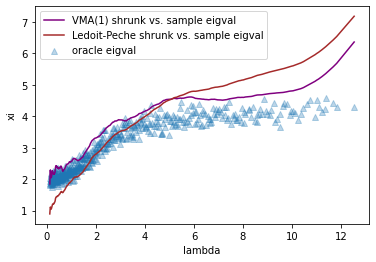

In [137]:
shrinkage_2.plot_with_oracle(
    xi_oracle=sample_2.xi_oracle,
    show_LP=True,
    savefig='figures\C_clusters_2_Student_VMA_1_oracle.png'
)

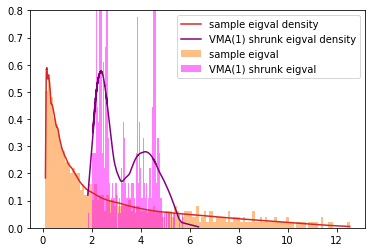

In [140]:
shrinkage_2.hist(
    show_lambdas=True,
    show_xi=True,
    show_lambdas_density=True,
    show_xi_density=True,
    ylim=(0, 0.8),
    savefig='figures\C_clusters_2_Student_VMA_1_hist.png'
)

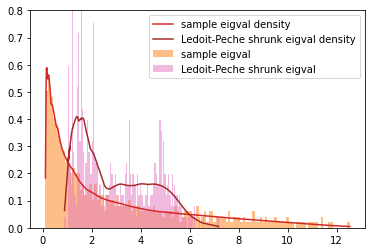

In [142]:
shrinkage_2.hist(
    show_lambdas=True,
    show_xi_LP=True,
    show_lambdas_density=True,
    show_xi_LP_density=True,
    ylim=(0, 0.8),
    savefig='figures\C_clusters_2_Student_VMA_1_hist_LP.png'
)

#### Fitting VARMA parameters

Let's now approach the problem differently: Choose a family of shrinkage models, say a one-parameter ($\tau$) exp-decay family, dependent not on any oracular knowledge of the data-generating process, rather on the basis of simplicity and robustness. Now, _fit_ this family to the out-of-sample eigenvalues `sample_2.xi_oracle`, by minimizing a loss function (`loss='mse'` by default).

Afterwards, the loss values for every grid entry reside in a list `loss_list`. Moreover, the best set of parameters from the grid (the attribute `params_dict_best`) is chosen, and the `predict` method is executed, so that the `xi` attribute now has the "best" shrunk eigenvalues. We keep also the best loss (i.e., the minimum of `loss_list`) in the attribute `loss_best`, along `loss_LP`, which is the loss corresponding to the Ledoit-Péché shrunk eigenvalues, for comparison.

In [145]:
tau_list = np.arange(0.1, 5.1, 0.1)
grid = [{'tau': tau} for tau in tau_list]
len(grid)

50

In [146]:
shrinkage_2b = VarmaShrinkage(
    lambdas=sample_2.E_eigval,
    T=sample_2.T
)
shrinkage_2b.fit(
    xi_oracle=sample_2.xi_oracle,
    optimizer='brute',
    grid=grid
)

  0%|          | 0/50 [00:00<?, ?it/s]

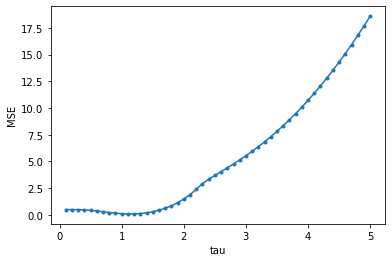

In [147]:
plt.plot(tau_list, shrinkage_2b.loss_list, marker='.')
plt.xlabel('tau')
plt.ylabel('MSE')
plt.show()

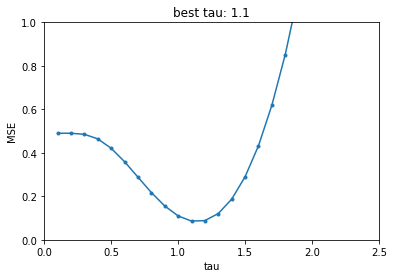

In [148]:
plt.plot(tau_list, shrinkage_2b.loss_list, marker='.')
plt.xlabel('tau')
plt.ylabel('MSE')
plt.xlim(0, 2.5)
plt.ylim(0, 1)
plt.title(f"best tau: {shrinkage_2b.params_dict_best['tau']}")
plt.savefig('figures\C_clusters_2_Student_VMA_1_best_tau.png')

In [149]:
shrinkage_2b.get_params()

{'a_list': array([0.91524827]), 'b_list': array([0.40289032])}

Fitting errors:

In [150]:
print('Errors:')
print(f'- Best (across the grid) {shrinkage_2b.name} shrinkage: {shrinkage_2b.loss_best}')
print(f'- Ledoit-Peche shrinkage: {shrinkage_2b.loss_LP}')

Errors:
- Best (across the grid) VAR(1) shrinkage: 0.085983516251398
- Ledoit-Peche shrinkage: 0.49014319513928645


Frobenius ratios:

In [151]:
print('Frobenius ratio:')
print(f'- Best (across the grid) {shrinkage_2b.name} shrinkage: {sample_2.frobenius_ratio(x=shrinkage_2b.xi)}')
print(f'- Ledoit-Peche shrinkage: {sample_2.frobenius_ratio(x=shrinkage_2b.xi_LP)}')
print(f'- Oracle shrinkage: {sample_2.frobenius_ratio(x=sample_2.xi_oracle)}')

Frobenius ratio:
- Best (across the grid) VAR(1) shrinkage: 0.24406259234162714
- Ledoit-Peche shrinkage: 0.3326344337655204
- Oracle shrinkage: 0.22574868891696367


Plots:

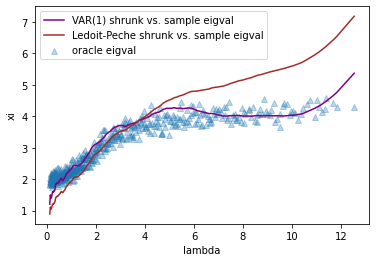

In [152]:
shrinkage_2b.plot_with_oracle(
    xi_oracle=sample_2.xi_oracle,
    show_LP=True,
    savefig='figures\C_clusters_2_Student_VMA_1_best_tau_oracle.png'
)

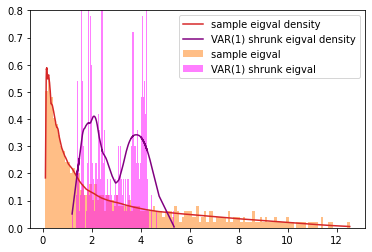

In [153]:
shrinkage_2b.hist(
    show_lambdas=True,
    show_xi=True,
    show_lambdas_density=True,
    show_xi_density=True,
    ylim=(0, 0.8),
    savefig='figures\C_clusters_2_Student_VMA_1_best_tau_hist.png'
)

### 2.4.6. Example: (Brute-force) fitting $\tau$ to a S&P 500 dataset

So far we have worked with synthetic (simulated) datasets. But equally well, we may load in a prepared data matrix $\mathbf{Y}$, only making sure it is in the correct format, that is an $N \times T_{\textrm{total}}$ array. To this end, we have a convenience function `load_Y` in the `shrinkage.datasets` module.

Furthermore, there is a `datasets` subdirectory, which contains some prepared real-world data. (Note that we may execute this module, `py -m datasets`; it'll generate the included datasets in the correct format from initial datasets, which come from known sources online.)

In [154]:
from shrinkage.datasets import load_Y

We will demonstrate the above fitting procedure for a financial dataset of returns of the S&P 500 stock index.

In [156]:
Y = load_Y(dataset_name='sp500_5yr')

Y.shape

(470, 1258)

We may now employ the same class, `SampleEigenvalues`, that we have used extensively for simulation. We simply instantiate it with `method='load'` and a matrix `Y` (and `T`) instead of the simulation attributes like `dist`, `C_model`, `A_model`, etc.

Here we choose `T` in such a way so as to have $q = N/T = 0.5$, like in all the synthetic examples above. We also immediately calculate the oracle estimator via the out-of-sample procedure (by setting `T_out`).

In [158]:
sample_3 = SampleEigenvalues(
    method='load',
    T=2 * Y.shape[0],
    Y=Y,
    T_out=50
)

There is one subtlety here: this dataset has a number of _outlying_ sample eigenvalues, separate from the _bulk_. For greater visibility, let's remove some number of top eigenvalues from the spectrum, before embarking on a shrinkage analysis.

Fit exp-decay shrinkage:

In [159]:
tau_list = np.arange(0.1, 3.1, 0.1)
grid = [{'tau': tau} for tau in tau_list]
len(grid)

30

In [169]:
n_top = 10

shrinkage_3 = VarmaShrinkage(
    lambdas=sample_3.E_eigval[:-n_top],
    T=sample_3.T
)
shrinkage_3.fit(
    xi_oracle=sample_3.xi_oracle[:-n_top],
    optimizer='brute',
    grid=grid
)

  0%|          | 0/30 [00:00<?, ?it/s]

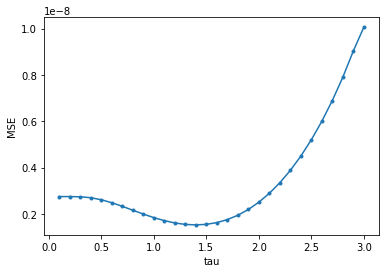

In [177]:
plt.plot(tau_list, shrinkage_3.loss_list, marker='.')
plt.xlabel('tau')
plt.ylabel('MSE')
plt.savefig('figures\SP500_best_tau.png')

In [171]:
shrinkage_3.params_dict_best

{'tau': 1.4000000000000001}

In [172]:
shrinkage_3.get_params()

{'a_list': array([0.87197991]), 'b_list': array([0.48954166])}

In [173]:
print('Errors:')
print(f'- Best (across the grid) {shrinkage_3.name} shrinkage: {shrinkage_3.loss_best}')
print(f'- Ledoit-Peche shrinkage: {shrinkage_3.loss_LP}')

Errors:
- Best (across the grid) VAR(1) shrinkage: 1.52300866662827e-09
- Ledoit-Peche shrinkage: 2.747204083506547e-09


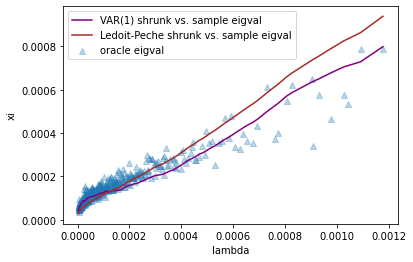

In [178]:
shrinkage_3.plot_with_oracle(
    xi_oracle=sample_3.xi_oracle[:-n_top],
    show_LP=True,
    savefig='figures\SP500_best_tau_oracle.png'
)

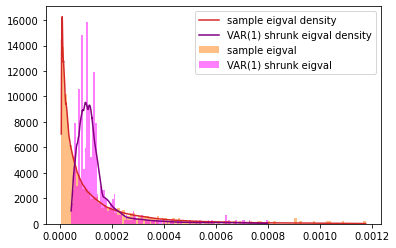

In [179]:
shrinkage_3.hist(
    show_lambdas=True,
    show_xi=True,
    show_lambdas_density=True,
    show_xi_density=True,
    savefig='figures\SP500_best_tau_hist.png'
)